### PART 1 — Dataset Preparation & Splitting

##### Objective of Part 1

Verify dataset integrity

Create train / validation / test splits

Preserve class balance

Prepare directory structure compatible with PyTorch

Perform sanity checks

### Step1 - Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step2 - Define Dataset Paths

In [2]:
import os

data_dir = "/content/drive/MyDrive/Urban Trees"

healthy_dir = os.path.join(data_dir, "healthy")
moderate_dir = os.path.join(data_dir, "moderate")
unhealthy_dir = os.path.join(data_dir, "unhealthy")

print("Healthy images:", len(os.listdir(healthy_dir)))
print("Moderate images:", len(os.listdir(moderate_dir)))
print("Unhealthy images:", len(os.listdir(unhealthy_dir)))

Healthy images: 300
Moderate images: 300
Unhealthy images: 300


### Step3 - Create Train / Val / Test Folder Structure

In [4]:
split_dir = "/content/UrbanTrees_Split"

splits = ["train", "val", "test"]
classes = ["healthy", "moderate", "unhealthy"]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

print("Split directories created.")

Split directories created.


#### Step4 - Split Images Class-wise

In [5]:
import random
import shutil

random.seed(42)

def split_and_copy(src_dir, class_name):
    images = os.listdir(src_dir)
    random.shuffle(images)

    total = len(images)
    train_end = int(0.7 * total)
    val_end = int(0.85 * total)

    splits_map = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in splits_map.items():
        for file in files:
            src = os.path.join(src_dir, file)
            dst = os.path.join(split_dir, split, class_name, file)
            shutil.copy(src, dst)

    print(f"{class_name}: {len(splits_map['train'])} train,"
          f" {len(splits_map['val'])} val,"
          f" {len(splits_map['test'])} test")

In [6]:
split_and_copy(healthy_dir, "healthy")
split_and_copy(moderate_dir, "moderate")
split_and_copy(unhealthy_dir, "unhealthy")

healthy: 210 train, 45 val, 45 test
moderate: 210 train, 45 val, 45 test
unhealthy: 210 train, 45 val, 45 test


### Step5 - Final Dataset Sanity Check

In [7]:
def count_images(base_dir):
    for split in splits:
        print(f"\n{split.upper()}")
        for cls in classes:
            path = os.path.join(base_dir, split, cls)
            print(f"{cls}: {len(os.listdir(path))}")

count_images(split_dir)


TRAIN
healthy: 210
moderate: 210
unhealthy: 210

VAL
healthy: 45
moderate: 45
unhealthy: 45

TEST
healthy: 45
moderate: 45
unhealthy: 45


## PART 2 — Data Loading & Augmentation

#### Objective of Part 2

Define image preprocessing pipeline

Apply data augmentation (train only)

Create ImageFolder datasets

Create efficient DataLoaders

Verify class mappings

Visualize sample batches (sanity check)

### Step 1 - Import Required Libraries

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### Step 2 - Define Dataset Root

In [9]:
split_dir = "/content/UrbanTrees_Split"

train_dir = f"{split_dir}/train"
val_dir   = f"{split_dir}/val"
test_dir  = f"{split_dir}/test"

### Step 3 - Define Image Transformations

In [10]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

### Step 4 - Create PyTorch Datasets

In [11]:
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=val_dir,
    transform=val_test_transforms
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=val_test_transforms
)

### Step 5 - Verify Class-to-Index Mapping

In [12]:
print("Class mapping:")
print(train_dataset.class_to_idx)

Class mapping:
{'healthy': 0, 'moderate': 1, 'unhealthy': 2}


### Step 6 - Create DataLoaders

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2 

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

### Step 7 - Device Configuration

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Step 8 - Visualize a Batch of Training Images (Sanity Check)

In [15]:
def show_batch(images, labels, class_names):
    images = images.numpy().transpose((0, 2, 3, 1))
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for i in range(6):
        axes[i].imshow(images[i])
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")
    plt.show()

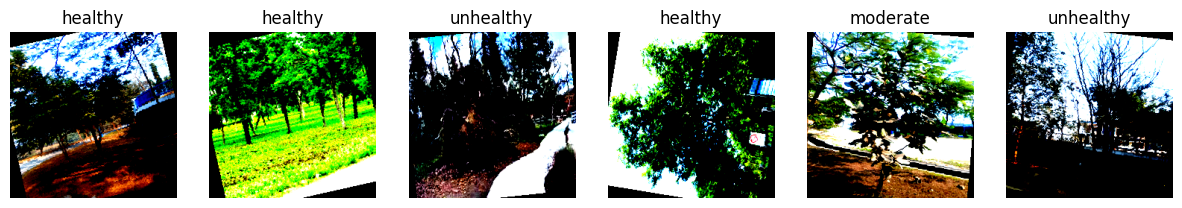

In [16]:
images, labels = next(iter(train_loader))
show_batch(images, labels, train_dataset.classes)

### Step 9 - Dataset Size Summary

In [17]:
print("Dataset sizes:")
print("Train:", len(train_dataset))
print("Validation:", len(val_dataset))
print("Test:", len(test_dataset))

Dataset sizes:
Train: 630
Validation: 135
Test: 135


## PART 3 — MobileNetV2 Model Setup

### Objective of Part 3

Load pretrained MobileNetV2

Inspect architecture

Freeze feature extractor (transfer learning)

Replace classifier for 3 classes

Move model to GPU/CPU

Verify forward pass

### Step 1 - Import Required Modules

In [18]:
import torch
import torch.nn as nn
from torchvision import models

### Step 2 - Load Pretrained MobileNetV2

In [19]:
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 133MB/s]


In [20]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Step 4 - Freeze Feature Extractor Layers

Prevents overfitting

Faster convergence

In [21]:
for param in model.features.parameters():
    param.requires_grad = False

### Step 5 - Replace the Classifier Head

In [22]:
num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_features, 3)
)

In [23]:
model = model.to(device)

### Step 6 - Verify Trainable Parameters

In [24]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")

Trainable parameters: 3843
Total parameters: 2227715


### Step 7 - Loss Function & Optimizer

#### Loss Function

In [25]:
criterion = nn.CrossEntropyLoss()

##### Optimizer (Classifier Only)

In [26]:
optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=0.001
)

### Step 8 - Forward Pass Sanity Check

In [27]:
images, labels = next(iter(train_loader))
images = images.to(device)

outputs = model(images)
print("Output shape:", outputs.shape)

Output shape: torch.Size([32, 3])


## PART 4 — Model Training & Validation

#### Objective of Part 4

Implement training loop

Implement validation loop

Track loss and accuracy

Save best model

Plot learning curves

### Step 1  - Import Utilities

In [28]:
from tqdm import tqdm
import copy

### Step 2 - Accuracy Calculation Function

In [29]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels)
    return correct.double() / labels.size(0)

### Step 3 - Training + Validation Loop

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10
):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # TRAINING 
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples

        # VALIDATION 
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)
                val_samples += labels.size(0)

        epoch_val_loss = val_loss / val_samples
        epoch_val_acc = val_corrects.double() / val_samples

        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc.item())
        history["val_acc"].append(epoch_val_acc.item())

        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.4f}")

        # SAVE BEST MODEL 
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print("\nTraining complete")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history

### Step 4 - Train the Model

In [31]:
NUM_EPOCHS = 30

model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=NUM_EPOCHS
)


Epoch 1/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Train Loss: 1.1043 | Train Acc: 0.4286
Val   Loss: 0.9226 | Val   Acc: 0.5852

Epoch 2/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Train Loss: 0.8778 | Train Acc: 0.5937
Val   Loss: 0.7923 | Val   Acc: 0.6370

Epoch 3/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Train Loss: 0.8190 | Train Acc: 0.6444
Val   Loss: 0.7181 | Val   Acc: 0.6667

Epoch 4/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Train Loss: 0.7710 | Train Acc: 0.6651
Val   Loss: 0.6749 | Val   Acc: 0.6889

Epoch 5/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Train Loss: 0.7808 | Train Acc: 0.6397
Val   Loss: 0.6486 | Val   Acc: 0.7407

Epoch 6/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Train Loss: 0.7110 | Train Acc: 0.6794
Val   Loss: 0.6938 | Val   Acc: 0.6815

Epoch 7/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Train Loss: 0.7306 | Train Acc: 0.6794
Val   Loss: 0.6276 | Val   Acc: 0.7333

Epoch 8/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Train Loss: 0.6860 | Train Acc: 0.7095
Val   Loss: 0.6171 | Val   Acc: 0.7407

Epoch 9/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Train Loss: 0.6722 | Train Acc: 0.6937
Val   Loss: 0.6082 | Val   Acc: 0.7333

Epoch 10/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Train Loss: 0.6858 | Train Acc: 0.6889
Val   Loss: 0.6381 | Val   Acc: 0.6815

Epoch 11/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Train Loss: 0.6533 | Train Acc: 0.7079
Val   Loss: 0.5980 | Val   Acc: 0.7259

Epoch 12/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Train Loss: 0.6603 | Train Acc: 0.7095
Val   Loss: 0.6672 | Val   Acc: 0.6667

Epoch 13/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Train Loss: 0.6838 | Train Acc: 0.6921
Val   Loss: 0.6064 | Val   Acc: 0.7556

Epoch 14/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Train Loss: 0.6508 | Train Acc: 0.7079
Val   Loss: 0.6222 | Val   Acc: 0.6815

Epoch 15/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Train Loss: 0.6559 | Train Acc: 0.6984
Val   Loss: 0.5810 | Val   Acc: 0.7556

Epoch 16/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Train Loss: 0.6124 | Train Acc: 0.7429
Val   Loss: 0.5722 | Val   Acc: 0.7704

Epoch 17/30
------------------------------


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Train Loss: 0.6147 | Train Acc: 0.7302
Val   Loss: 0.5945 | Val   Acc: 0.7185

Epoch 18/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Train Loss: 0.6652 | Train Acc: 0.7159
Val   Loss: 0.6052 | Val   Acc: 0.7333

Epoch 19/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Train Loss: 0.6646 | Train Acc: 0.7079
Val   Loss: 0.6346 | Val   Acc: 0.6815

Epoch 20/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Train Loss: 0.6386 | Train Acc: 0.7190
Val   Loss: 0.6608 | Val   Acc: 0.6667

Epoch 21/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Train Loss: 0.6373 | Train Acc: 0.7190
Val   Loss: 0.5896 | Val   Acc: 0.7556

Epoch 22/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Train Loss: 0.6162 | Train Acc: 0.7333
Val   Loss: 0.6104 | Val   Acc: 0.7111

Epoch 23/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.33it/s]


Train Loss: 0.6208 | Train Acc: 0.7190
Val   Loss: 0.6098 | Val   Acc: 0.7037

Epoch 24/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Train Loss: 0.6459 | Train Acc: 0.7079
Val   Loss: 0.5955 | Val   Acc: 0.7556

Epoch 25/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Train Loss: 0.6240 | Train Acc: 0.7429
Val   Loss: 0.5775 | Val   Acc: 0.7407

Epoch 26/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Train Loss: 0.6439 | Train Acc: 0.7254
Val   Loss: 0.5788 | Val   Acc: 0.7556

Epoch 27/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Train Loss: 0.6025 | Train Acc: 0.7222
Val   Loss: 0.6011 | Val   Acc: 0.7037

Epoch 28/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Train Loss: 0.5899 | Train Acc: 0.7349
Val   Loss: 0.5965 | Val   Acc: 0.7407

Epoch 29/30
------------------------------


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Train Loss: 0.5949 | Train Acc: 0.7381
Val   Loss: 0.6199 | Val   Acc: 0.7407

Epoch 30/30
------------------------------


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Train Loss: 0.6186 | Train Acc: 0.7032
Val   Loss: 0.5751 | Val   Acc: 0.7556

Training complete
Best Validation Accuracy: 0.7704


### Step 5 - Save the Best Model

In [33]:
model_path = "/content/drive/MyDrive/mobilenetv2_tree_health.pth"
torch.save(model.state_dict(), model_path)

print("Model saved at:", model_path)

Model saved at: /content/drive/MyDrive/mobilenetv2_tree_health.pth


### Step 6 - Plot Training Curves

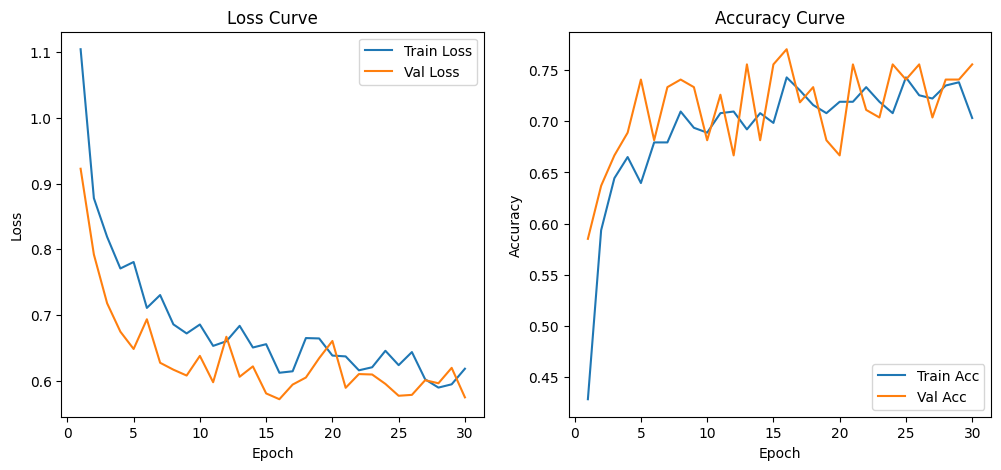

In [34]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

## PART 5 — Model Evaluation on Test Set

#### Objective of Part 5

Load best-trained model

Run inference on unseen test data

Compute:

Overall accuracy

Confusion matrix

Precision, Recall, F1-score (per class)

Visualize misclassifications

Plot confusion matrix

### Step 1 - Import Required Libraries

In [35]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
import seaborn as sns

### Step 2 - Load the Trained Model Weights

In [36]:
model.load_state_dict(
    torch.load("/content/drive/MyDrive/mobilenetv2_tree_health.pth",
               map_location=device)
)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Step 3 - Run Inference on Test Set

In [37]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

### Step 4 - Overall Test Accuracy

In [38]:
import numpy as np

test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6741


### Step 5 - Confusion Matrix

In [39]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)

[[34  7  4]
 [11 26  8]
 [ 5  9 31]]


### Step 6 - Confusion Matrix Visualization

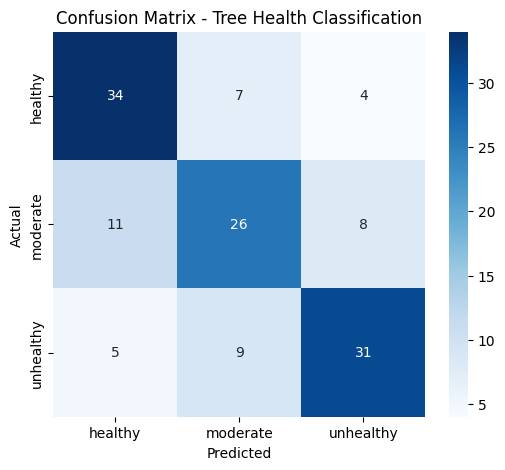

In [40]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_dataset.classes,
    yticklabels=train_dataset.classes
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tree Health Classification")
plt.show()

### Step 7 - Precision, Recall, F1-Score (Per Class)

In [41]:
report = classification_report(
    all_labels,
    all_preds,
    target_names=train_dataset.classes
)

print(report)

              precision    recall  f1-score   support

     healthy       0.68      0.76      0.72        45
    moderate       0.62      0.58      0.60        45
   unhealthy       0.72      0.69      0.70        45

    accuracy                           0.67       135
   macro avg       0.67      0.67      0.67       135
weighted avg       0.67      0.67      0.67       135



### Step 8 - Identify Misclassified Samples (Analysis)

In [42]:
misclassified = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((
                    inputs[i].cpu(),
                    labels[i].cpu(),
                    preds[i].cpu()
                ))

### Step 9 - Visualize Some Misclassifications

In [43]:
def show_misclassified(samples, class_names, num=6):
    plt.figure(figsize=(15, 5))

    for i in range(num):
        img, true_label, pred_label = samples[i]
        img = denormalize(img)

        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(f"T:{class_names[true_label]} | P:{class_names[pred_label]}")
        plt.axis("off")

    plt.show()

### Step 10 - Define denormalize()

In [44]:
import numpy as np

def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = img_tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

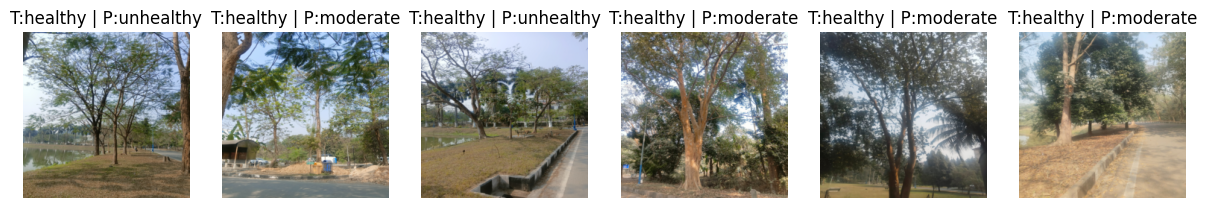

In [45]:
show_misclassified(misclassified, train_dataset.classes)

## PART 6 — Single Image Inference & Deployment Pipeline

### Objective of Part 6

Load trained MobileNetV2

Predict tree health class for one image

Return confidence score

Create a reusable function for dashboard

### Step 1 - Define Class Names

In [46]:
CLASS_NAMES = ["healthy", "moderate", "unhealthy"]

### Step 2 - Image Preprocessing for Inference

In [47]:
from PIL import Image

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

### Step 3 - Load Trained Model

In [48]:
model = models.mobilenet_v2(pretrained=False)

num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 3)
)

model.load_state_dict(
    torch.load("/content/drive/MyDrive/mobilenetv2_tree_health.pth",
               map_location=device)
)

model = model.to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Step 4  - Single Image Prediction Function

In [49]:
import torch.nn.functional as F

def predict_tree_health(image_path):
    """
    Input: image file path
    Output: predicted class, confidence score
    """

    image = Image.open(image_path).convert("RGB")
    image = inference_transform(image)
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = F.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

    predicted_class = CLASS_NAMES[pred.item()]
    confidence = conf.item()

    return predicted_class, confidence

### Step 5 - Test Inference on Sample Image

In [50]:
test_image_path = "/content/drive/MyDrive/Urban Trees/healthy/img1.jpg"

pred_class, conf = predict_tree_health(test_image_path)

print("Predicted Class:", pred_class)
print("Confidence:", round(conf * 100, 2), "%")

Predicted Class: healthy
Confidence: 91.7 %


### Step 6 - Visualize Prediction Result

In [51]:
def show_prediction(image_path):
    img = Image.open(image_path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")

    pred, conf = predict_tree_health(image_path)
    plt.title(f"Prediction: {pred} ({conf*100:.2f}%)")
    plt.show()

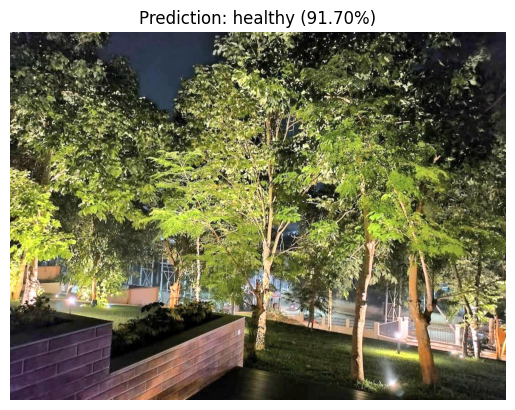

In [52]:
show_prediction(test_image_path)